## Кластерный анализ:

- Иерархический кластерный анализ
- Кластерный анализ методом к-средних (k-means)
- Кластерный анализ методом DBSCAN


## Активация библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing

# Данные:

In [13]:
DB = pd.read_csv('Econom_Cities_data.csv', sep=";", header = 0, index_col='City')

#  Размеры таблицы данных:
print('Размер данных:',DB.shape)

# Посмотрим на первые строки даннных:
DB.head(5)

Размер данных: (48, 3)


,Work,Price,Salary
City,,,
Amsterdam,1714,"65,6",49
Athens,1792,"53,8","30,4"
Bogota,2152,"37,9","11,5"
Bombay,2052,"30,3","5,3"
Brussels,1708,"73,8","50,5"


##### Описание данных:

- ***City*** - Название города
- ***Work*** - Взвешенное среднее числа рабочих часов, сосчитанное по 12 профессиям
- ***Price*** - Индекс цен 112 товаров и услуг, включая арендную плату за жилье (значение для Цюриха взято за 100%)
- ***Salary*** - Индекс заработной платы за час работы, сосчитанный по 12 профессиям после налогов и вычетов (значение для Цюриха взято за 100%)

In [9]:
#  Посмотрим на данные в каждом столбце таблицы:
DB.dtypes

,0
Work,int64
Price,object
Salary,object


In [16]:
# Меняем тип данных для Price, Salary с Object на Float:

DB['Price'] = DB['Price'].str.replace(',','.').astype(float)
DB['Salary'] = DB['Salary'].str.replace(',','.').astype(float)

DB.dtypes

,0
Work,int64
Price,float64
Salary,float64


# Описательные статистики для кадого столбца:

In [17]:
DB.describe(include=[np.number])

,Work,Price,Salary
count,48.000000,48.000000,48.000000
mean,1384.958333,68.860417,-378.727083
std,2404.897007,21.784659,2027.338052
min,-9999.000000,30.300000,-9999.000000
25%,1740.750000,49.650000,12.250000
50%,1834.500000,70.500000,40.300000
75%,1972.750000,81.700000,58.700000
max,2375.000000,115.500000,100.000000


В слолбцах Work и Salarу выбивающиеся отрицательные значения -999 .

Часы не могут быть отрицательными, индекс заработной платы тоже.

# Убераем отрицательные значения:

In [18]:
for i in range(len( DB['Salary'])):
    if DB['Salary'][i] < 0:
        DB['Salary'][i] = None

for i in range(len( DB['Work'])):
    if DB['Work'][i] < 0:
        DB['Work'][i] = None

# Удаляем строки с пропусками
DB = DB.dropna()

In [19]:
# Снова посмотрим на описательные статистики:
DB.describe(include=[np.number])

,Work,Price,Salary
count,46.000000,46.000000,46.000000
mean,1879.913043,70.100000,39.545652
std,174.342552,21.389177,24.757703
min,1583.000000,30.300000,2.700000
25%,1745.250000,51.775000,14.375000
50%,1849.000000,70.950000,43.650000
75%,1976.250000,81.900000,59.700000
max,2375.000000,115.500000,100.000000


# Cтандартизация данных
Так как у 3 переменных Work, Price, Salary разные размерности, необходимо стандартизировать данные:

In [21]:
scaler = preprocessing.StandardScaler()

# вычисляем параметры стандартизации (они сохраняются внутри объекта norm)
scaler.fit(DB)

# Преобразуем данные
df = scaler.transform(DB)

# Получаем объект X -- матрицу класса numpy.ndarray.
# Преобразуем её в объект класса pandas.DataFrame.
df = pd.DataFrame(df, index=DB.index, columns=DB.columns)

df.describe()

,Work,Price,Salary
count,4.600000e+01,4.600000e+01,4.600000e+01
mean,6.365681e-16,-4.247810e-16,1.061952e-16
std,1.011050e+00,1.011050e+00,1.011050e+00
min,-1.721863e+00,-1.881316e+00,-1.504695e+00
25%,-7.809400e-01,-8.662088e-01,-1.027914e+00
50%,-1.792714e-01,4.017885e-02,1.676125e-01
75%,5.586788e-01,5.577770e-01,8.230592e-01
max,2.871116e+00,2.146023e+00,2.468822e+00


# Иерархический кластерный анализ

In [23]:
X = df.copy()

#  Кластеризуем:
link = linkage(X, 'ward', 'euclidean')

### Параметры:

- method ='ward' - Используемый алгоритм соединения кластеров, чтобы понять насколько похожи кластеры точек
- metric ='euclidean' - Мера близости расстояний между наблюдениями


### Другие варинаты алгоритмов соединения кластеров:

- Среднее невзвешенное расстояние (Average linkage clustering) - Считается среднее попарных расстояний между точками
- Центроидный метод (Centroid Method) - Расстояние между кластерами равно расстоянию между их центрами тяжести (Центроидами)
- Метод дальнего соседа, максимального расстояния (Complete linkage Clustering)- Находится максимальное расстояние точек
- Метод ближайшего соседа (Single linkage clustering)- Находится минимальное расстояние из пар точек (Находит ленточные)
- Метод Варда (Ward's method) - Хорошо определяет шаровые скопления в один новый кластер объединяются те кластера, при объединении которых получается наименьший прирост общей суммы дистанций.

### Алгоритм иерархического кластерного анализа:

1) Каждый объека объявляется кластером

2) Находится два ближайших кластера и объединяется

3) Находятся следующте два ближайших кластера и так до объединения всех объектов в один кластер

4) Необходимо определиться в какой момент расстояние межу кластерами уже большое и необходимо останоиться

### Дендрограмма

Дендрограмма - древовидная диаграмма, которая представляет результаты иерархической кластеризации.

Показывает степень близости отдельных объектов и кластеров, а также наглядно демонстрирует в графическом виде последовательность их объединения


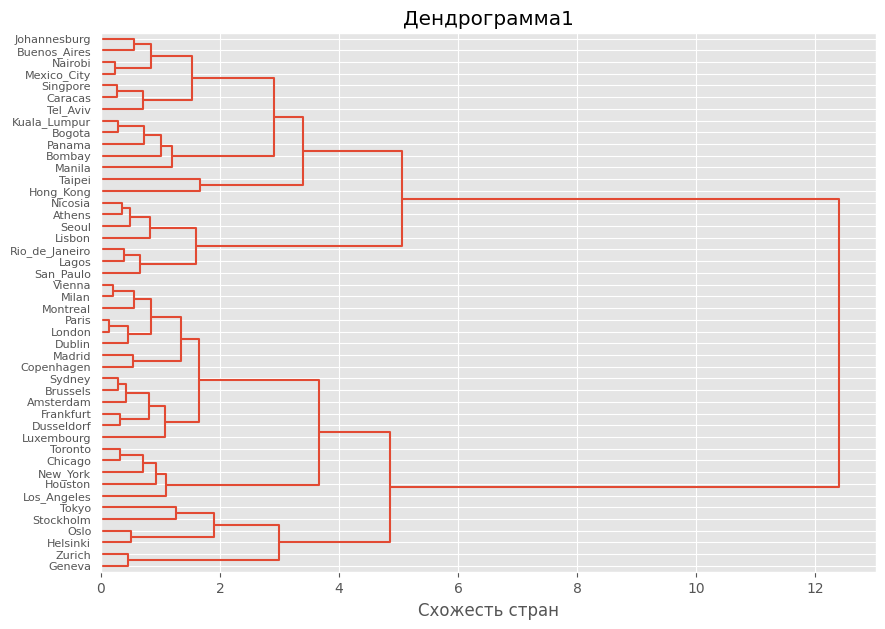

In [26]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Схожесть стран')
ax1.set_title('Дендрограмма1')
dn = dendrogram(link,
                # массив с названиями объектов для подписи по оси X
                labels=X.index.tolist(),
                leaf_font_size = 8,

                #  Убираем автоматическое определение числа кластеров
                color_threshold=-1,

                # повернуть подписи вертикально
                orientation = "right",
                leaf_rotation=0.)

### Каменистая осыпь
График, помогающий определить число кластеров. Особенно полезен, если данных много.

На графике "Каменистая осыпь" показывается зависимость расстояний между кластерами от шага объединения (обратного).

На графике находим момент, начиная с которого расстояние перестанет значительно меняться.

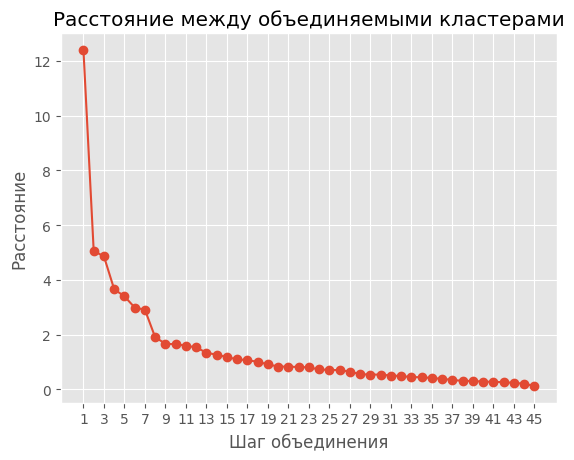

In [28]:
dist = link[:, 2] # Используем второй столбец матрицы link где хранятся расстояния между объединяемыми кластерами.
dist_rev = dist[::-1]

idxs = range(1, len(dist) + 1)

plt.plot(idxs, dist_rev, marker='o')
plt.xticks(np.arange(min(idxs), max(idxs)+1, 2.0))
plt.title('Расстояние между объединяемыми кластерами')
plt.xlabel('Шаг объединения')
plt.ylabel('Расстояние')

plt.show()

# Информация о кластерах добавляется в таблицу данных в виде столбца

In [29]:
# Останавливаем объединение на 8 кластерах:
X['cluster_8'] = fcluster(link, 8, criterion='maxclust')

# Посмотрим среднее значение кажого кластера:
X.groupby('cluster_8').mean().sort_values('Work')

,Work,Price,Salary
cluster_8,,,
4,-0.857780,0.379842,0.574532
2,-0.847631,2.068029,0.809787
5,-0.470061,-0.905544,-0.830288
1,-0.034291,1.316448,2.270759
3,0.464442,0.270380,0.814075
8,0.626820,-0.648264,-1.019892
7,1.528018,-1.414296,-1.251501
6,2.204206,0.186713,-0.342860


In [30]:
# Посмотрим какие города в каком кластере:
X.sort_values('cluster_8')

,Work,Price,Salary,cluster_8
City,,,,
Zurich,-0.069086,1.413350,2.468822,1
Geneva,0.000504,1.219546,2.072696,1
Tokyo,0.000504,2.122389,1.162013,2
Helsinki,-1.234729,2.056212,1.104840,2
Stockholm,-0.434437,1.947493,-0.014116,2
Oslo,-1.721863,2.146023,0.986410,2
Houston,0.568827,0.085085,0.275833,3
Los_Angeles,1.090757,0.458512,1.047667,3
New_York,0.360056,0.623954,1.072170,3


In [31]:
# Попробуем разбить на 4 кластеров:
X1 = df.copy()

#  Кластеризуем:
link = linkage(X1, 'ward', 'euclidean')

# Останавливаем объединение на 8 кластерах:
X1['cluster_4'] = fcluster(link, 4, criterion='maxclust')

# Посмотрим среднее значение кажого кластера:
X1.groupby('cluster_4').mean().sort_values('Work')

,Work,Price,Salary
cluster_4,,,
1,-0.576518,1.817502,1.296778
2,-0.509827,0.351036,0.637570
3,-0.470061,-0.905544,-0.830288
4,1.174017,-0.802564,-1.005891


In [ ]:
# Посмотрим какие города в каком кластере:
#X1.sort_values('cluster_4')

***Кластер 1***: города в этом кластере характеризуются высоким индексом цен (1,817502) и заработной платы (1,296778), при этом среднее количество рабочих часов меньше среднего (-0,576518).
В этот кластер включены столицы прибалтийских стран и стран, которые слитаются самыми дорогими для жизни такие как Хельсинки, Осло, Стокгольм, Токио, Женева, Цюрих.

***Кластер 2***: Города этого кластера отличаются средним индексом цен (0.351036) и средним индексом заработной платы (0.351036), а также низким количеством рабочих часов (-0.509827).
В данный кластер входят крупные города  Северной Америки такие как Торонто, Нью-Йорк, Лос-Анджелес, Чикаго и города центральной Европы

***Кластер 3***:Города этого кластера имеют низкий индекс цен (-0.905544), но при этом индексы заработной платы и рабочего времени также низкие (-0,830288 и -0.470061 соответственно). Это может означать, что в этих городах уровень жизни невысок, цены на товары и услуги низкие, а заработная плата и количество рабочих часов также невелики. В этот кластер входят города Южной Европы и два города Бразилии .

***Кластер 4:*** Города этого кластера характеризуются низким индексом цен и заработной платы (-0,802564; -1,005891), при этом количество рабочих часов самое боьшое среди кластеров (1,174017). Это может говорить о том, что в этих городах много рабочих мест, где люди очень много работают, чтобы заработать достаточно денег для поддержания низкого уровня жизни. В основном в кластере присутвуют города Африки, Азии и Латинской Америки.

# K-means

Метод k-средних стремится ***минимизировать суммарное квадратичное отклонение точек кластеров от центров этих кластеров***. Алгоритм работает следующим образом:

На каждой ***итерации*** определятеся:

1) К какому ближайшему центру кластера оносится каждый объект

2) Перевычисляются центры масс для каждого кластера

3) Векторы разбиваются на кластеры вновь в соответствии с ближайшими новыми центрами

Алгоритм завершается, когда на какой-то итерации не происходит изменения внутрикластерного расстояния.

Необходимо заранее знать число кластеров.

**K-Means++:** первый центроид выбирается случайно, а затем выбираются остальные центроиды с вероятностью, пропорциональной квадрату расстояния до ближайшего уже выбранного центроида

In [ ]:
#  Используем процедуру KMeans из библиотеки sklearn
from sklearn.cluster import KMeans

In [ ]:
# Берём те же данные после стандартизации методом StandardScaler():
df1 = df.copy()

### Каменистая осыпь

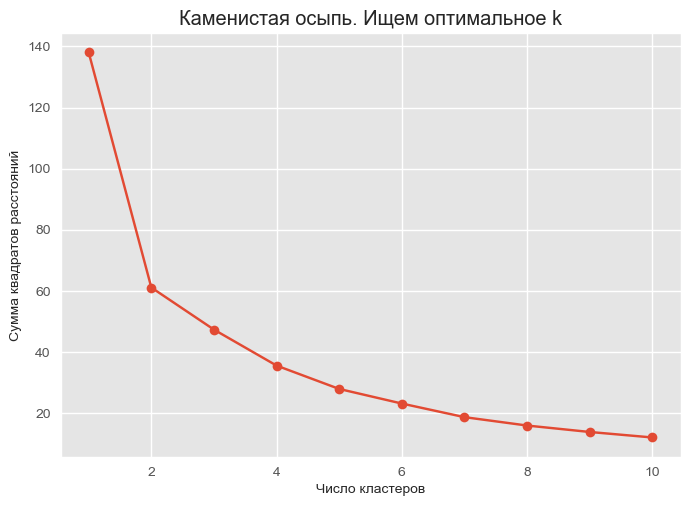

In [ ]:
# При работе с методом K-means необходимо сразу указывать число кластеров.

# Строим модель для разного числа кластеров, чтобы построить график каменистой осыпи.
# Кластеризация считается условно хорошей, если инерция перестаёт сильно уменьшаться при увеличении числа кластеров.

# Берём число кластеров от 1 до 10:
K = range(1, 11)

# Вычисляем значения критерия качества для разного числа кластеров:
models = [KMeans(n_clusters=k, random_state=42).fit(df1) for k in K]

# Метод ```inertia_``` вернёт сумму квадратов расстояний от каждой точки данных до центра ближайшего к ней кластера:
dist = [model.inertia_ for model in models]

# Строим график каменистая осыпь
plt.plot(K, dist, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Каменистая осыпь. Ищем оптимальное k')
plt.show()

In [ ]:
# Инициализация модели для определенного числа кластеров:

max_iter_1 = 1000
model = KMeans(n_clusters=4, random_state=42, max_iter=max_iter_1, n_init=10,
               verbose=0, tol=0.0001 )


# Параметры модели:

# n_clusters - Колличество кластеров
# random_state - Зерно датчика случайных чисел для выбора начальных центров кластеров
# max_iter - Максимальное число итераций
# n_init - Сколько раз делать кластеризацию с разными начальными центрами кластеров
# verbose - Параметр 0 - не выдавать промежуточные результаты
# tol - Пороговое значения изменения критерия качества


In [ ]:
# Кластеризация данных из таблицы df1
# Строим модель методом fit()

model.fit(df1)

KMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=42)

In [ ]:
####  Результаты кластеризации

#  Результат кластеризации набора данных из таблицы df
#  Номера кластеров начинаются с 0, а не с 1, как в иерархическом кластерном анализе
df1['clusters'] = model.labels_
model.labels_
df1.sort_values('clusters')

,Work,Price,Salary,clusters
City,,,,
Kuala_Lumpur,1.664879,-1.257362,-1.210663,0
Bogota,1.577891,-1.522069,-1.145323,0
Bombay,0.997969,-1.881316,-1.398517,0
Tel_Aviv,0.783398,-0.132354,-0.512337,0
Taipei,1.537296,0.671223,-0.206053,0
Caracas,0.934178,-0.430150,-1.169825,0
Singpore,0.939977,-0.269435,-0.957469,0
Manila,2.250600,-1.422804,-1.451606,0
Panama,1.148749,-0.987927,-1.051396,0


In [ ]:
# Посмотрим средние значения среди кластеров:
df1.groupby('clusters').mean()

,Work,Price,Salary
clusters,,,
0,1.470605,-0.752999,-0.958286
1,-0.456269,0.267488,0.631362
2,-0.673655,1.628425,1.145167
3,-0.141840,-0.913156,-0.937421


In [ ]:
#  Таблица сопряженности для двух кластеризаций

tab1 = pd.crosstab(X1['cluster_4'], df1['clusters'])
print(tab1)

clusters    0   1  2  3
cluster_4              
1           0   0  6  0
2           0  17  2  0
3           0   0  0  7
4          10   0  0  4


# DBSCAN

In [ ]:
#  Активируем процедуру DBSCAN
from sklearn.cluster import DBSCAN

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** — это алгоритм кластеризации данных, основанный на плотности.

Он группирует точки, расположенные рядом друг с другом, и помечает точки, находящиеся одиноко в областях с низкой плотностью.

DBSCAN использует два параметра: **ε** (эпсилон) и **M** - минимальное количество ближайших соседей, пороговое значение.

Третий параметр - Формула для подсчета расстояний между точками

Алгоритм находит кластеры произвольной формы и устойчив к выбросам.

В ε - окрестности **высокая плотность точек**, если в нее попало **не менее M точек**. Иначе плотность низкая.

X и Y считаются **соседями** если **X попала в ε - окрестность точки Y**.


Три типа точек в DBSCAN:
- корневые
- граничные
- выбросы


Алгоритм кластеризации:

- Шаг 1: Кластеризация корневых точек (и только корневых)
- Шаг 2: Распределение граничных точек по кластерам
- Шаг 3: Кластер из выбросов

In [ ]:
df3 = df.copy()

#  Кластеризуем методом DBSCAN.
#  Значения 3-х первых параметров совпадают со значениями "по умолчанию".

dbscan_1 = DBSCAN(eps=0.5, metric='euclidean', min_samples=5)

#  Обучим модель DBSCAN
dbscan_1.fit(df3)

# Numpy массив номеров кластеров
dbscan_1.labels_

array([ 0, -1, -1, -1,  0, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  0, -1, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1,  0,
       -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1], dtype=int64)

#  Таблица частот в pandas

In [ ]:
#  Команда value_counts() работает с таблицами
#  Поэтому предварительно надо матрицу преобразовать в таблицу

table_ = pd.value_counts(pd.Series(dbscan_1.labels_))
table_.sort_index(inplace=True)

print(table_)

-1    36
 0    10
dtype: int64


In [ ]:
# Подбираем параметры.
# Увеличиваем eps до 3

dbscan_1 = DBSCAN(eps=3, metric='euclidean', min_samples=5)

dbscan_1.fit(df3)

#  Таблица частот

unique, counts = np.unique(dbscan_1.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 0 46]]


In [ ]:
dbscan_2 = DBSCAN(eps= 0.5 ,metric='euclidean', min_samples=2)

dbscan_2.fit(df3)

#  Таблица частот
unique, counts = np.unique(dbscan_2.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[-1 17]
 [ 0 14]
 [ 1  3]
 [ 2  2]
 [ 3  6]
 [ 4  2]
 [ 5  2]]


In [ ]:
dbscan_3 = DBSCAN(eps=0.9, metric='euclidean', min_samples=2)

dbscan_3.fit(df3)

unique, counts = np.unique(dbscan_3.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[-1  4]
 [ 0 38]
 [ 1  2]
 [ 2  2]]


#### Silhouette для автоматического определения значений параметров

In [ ]:
#  Активируем процедуры измерения качества кластеризации
#  Будет нужна процедура силуэт

from sklearn import metrics

Коэффициент silhouette для каждого объекта показывает, насколько объект похож на свой кластер по сравнению с другими кластерами.

Он рассчитывается как разница между средним внутрикластерным сходством (компактностью) и средним межкластерным расстоянием (отделимостью), делённая на максимальное из этих двух значений:

s(i) = (b(i) − a(i)) / max(a(i), b(i)).

Здесь:

s(i) — коэффициент silhouette для i-го объекта;
a(i) — среднее расстояние от i-го объекта до других объектов в том же кластере;
b(i) — минимальное среднее расстояние от i-го объекта до объектов в других кластерах.

Если коэффициент silhouette близок к 1, это означает, что объект сильно похож на свой кластер и плохо подходит другим кластерам. Это указывает на высокую компактность и отделимость.

Если коэффициент silhouette близок к -1, это значит, что объект плохо распределён по своему кластеру и лучше подходит другим кластерам, указывая на низкую компактность или отделимость (или оба этих параметра).

In [ ]:
#  Создаём списки тех значений параметров, которые собираюся перебирать
eps_1 = [0.5, 0.75, 0.95, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
min_samples_1 = [2, 3, 4, 5, 7, 10, 12, 15, 20, 25]

In [ ]:
sil_avg = []

#  Для сохранения наилучшено набора параметров
max_value = [0, 0, 0, -1]

In [ ]:
#  Перебираю все пары значений параметров
#  Сохраняю лучшее решение

for i in range(len(eps_1)):
    for j in range(len(min_samples_1)):

        db = DBSCAN(min_samples = min_samples_1[j], eps =eps_1[i]).fit(df3)

        labels = db.labels_

        # Число кластеров, после отбрасывания выбросов.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

        # Число выбросов.
        # n_noise_ = list(labels).count(-1)

        if n_clusters_ > 1:
            silhouette_avg = metrics.silhouette_score(df3, labels)
            if silhouette_avg > max_value[3]:
                max_value=(eps_1[i], min_samples_1[j], n_clusters_, silhouette_avg)
            sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0],
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 0.75 
min_sample= 2 
number of clusters= 4 
average silhouette score= 0.3935


In [ ]:
#  Добавляем требование полного перебора, algorithm= 'brute'

dbscan_3 = DBSCAN(eps=0.75, metric='euclidean', min_samples=2, algorithm= 'brute')
dbscan_3.fit(df3)

unique, counts = np.unique(dbscan_3.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[-1  4]
 [ 0 19]
 [ 1 19]
 [ 2  2]
 [ 3  2]]


In [ ]:
df3['dbscan'] = dbscan_3.labels_
df3['dbscan'].sort_values()

City
Tokyo            -1
Taipei           -1
Stockholm        -1
Hong_Kong        -1
Amsterdam         0
Toronto           0
Sydney            0
Paris             0
New_York          0
Montreal          0
Milan             0
Madrid            0
Vienna            0
Los_Angeles       0
London            0
Luxembourg        0
Houston           0
Chicago           0
Copenhagen        0
Brussels          0
Frankfurt         0
Dusseldorf        0
Dublin            0
Johannesburg      1
Seoul             1
Buenos_Aires      1
San_Paulo         1
Bombay            1
Tel_Aviv          1
Bogota            1
Athens            1
Singpore          1
Rio_de_Janeiro    1
Nicosia           1
Panama            1
Nairobi           1
Mexico_City       1
Manila            1
Lisbon            1
Lagos             1
Kuala_Lumpur      1
Caracas           1
Geneva            2
Zurich            2
Oslo              3
Helsinki          3
Name: dbscan, dtype: int64

In [ ]:
#  Таблица сопряженности для двух кластеризаций
tab1 = pd.crosstab(X1['cluster_4'], df3['dbscan'])
print(tab1)

dbscan     -1   0   1   2   3
cluster_4                    
1           2   0   0   2   2
2           0  19   0   0   0
3           0   0   7   0   0
4           2   0  12   0   0
